Install dependencies

In [4]:
!pip -q install --force-reinstall --no-cache-dir \
  numpy==2.0.2 \
  pandas==2.2.2 \
  scipy==1.14.1 \
  scikit-learn==1.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 212.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 232.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 222.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 183.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 255.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 241.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 247.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 239.1 MB/s eta 0:00:00


check version

In [5]:
import numpy as np, pandas as pd, scipy, sklearn
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sklearn.__version__)

numpy: 2.0.2
pandas: 2.2.2
scipy: 1.14.1
sklearn: 1.6.1


Imports + seed

In [6]:
import os, json, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: Tesla T4


Upload CSV + load DataFrame

In [7]:
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Saving bbc_data.csv to bbc_data.csv
Loaded: bbc_data.csv
Shape: (2225, 2)
Columns: ['data', 'labels']


,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


Sanity checks + label mapping

In [8]:
TEXT_COL = "data"
LABEL_COL = "labels"

assert TEXT_COL in df.columns, f"Missing text column '{TEXT_COL}'"
assert LABEL_COL in df.columns, f"Missing label column '{LABEL_COL}'"

df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)

label_names = sorted(df[LABEL_COL].unique().tolist())
label2id = {l:i for i,l in enumerate(label_names)}
id2label = {i:l for l,i in label2id.items()}

print("Num labels:", len(label_names))
print("Labels:", label_names)
print(df[LABEL_COL].value_counts())

Num labels: 5
Labels: ['business', 'entertainment', 'politics', 'sport', 'tech']
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


Stratified train/val/test split (80/10/10)

In [9]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[LABEL_COL],
    random_state=SEED
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.125,  # 0.125 of 0.8 = 0.10 of total => 80/10/10
    stratify=train_df[LABEL_COL],
    random_state=SEED
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print("train:", train_df.shape, "val:", val_df.shape, "test:", test_df.shape)
print("train label dist:\n", train_df[LABEL_COL].value_counts(normalize=True))
print("val label dist:\n", val_df[LABEL_COL].value_counts(normalize=True))
print("test label dist:\n", test_df[LABEL_COL].value_counts(normalize=True))

train: (1557, 2) val: (223, 2) test: (445, 2)
train label dist:
 labels
sport            0.229929
business         0.229287
politics         0.186898
tech             0.180475
entertainment    0.173410
Name: proportion, dtype: float64
val label dist:
 labels
sport            0.228700
business         0.228700
politics         0.188341
tech             0.179372
entertainment    0.174888
Name: proportion, dtype: float64
test label dist:
 labels
business         0.229213
sport            0.229213
politics         0.188764
tech             0.179775
entertainment    0.173034
Name: proportion, dtype: float64


Build HF Datasets + add label_id

In [10]:
train_df["label_id"] = train_df[LABEL_COL].map(label2id)
val_df["label_id"]   = val_df[LABEL_COL].map(label2id)
test_df["label_id"]  = test_df[LABEL_COL].map(label2id)

ds_train = Dataset.from_pandas(train_df)
ds_val   = Dataset.from_pandas(val_df)
ds_test  = Dataset.from_pandas(test_df)

print(ds_train, ds_val, ds_test)

Dataset({
    features: ['data', 'labels', 'label_id'],
    num_rows: 1557
}) Dataset({
    features: ['data', 'labels', 'label_id'],
    num_rows: 223
}) Dataset({
    features: ['data', 'labels', 'label_id'],
    num_rows: 445
})


# Part A — Prompt Baseline (FLAN-T5)

Load FLAN-T5 (baseline prompt classifier)

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

BASELINE_MODEL_ID = "google/flan-t5-base"

baseline_tokenizer = AutoTokenizer.from_pretrained(BASELINE_MODEL_ID)
baseline_model = AutoModelForSeq2SeqLM.from_pretrained(BASELINE_MODEL_ID)

LABEL_SET = ", ".join(label_names)

def build_prompt(text: str) -> str:
    return (
        "You are a text classification assistant.\n"
        f"Task: Classify the article into exactly one of these labels: {LABEL_SET}.\n"
        "Return only the label name and nothing else.\n\n"
        f"Article:\n{text}\n\n"
        "Label:"
    )

def normalize_prediction(pred: str) -> str:
    pred_clean = pred.strip().replace('"', '').replace("'", "")
    pred_lower = pred_clean.lower()

    for lab in label_names:
        if pred_lower == lab.lower():
            return lab
    for lab in label_names:
        if lab.lower() in pred_lower:
            return lab

    return "UNKNOWN"

@torch.no_grad()
def classify_with_flan_t5(text: str, max_new_tokens: int = 6) -> str:
    prompt = build_prompt(text)
    inputs = baseline_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    outputs = baseline_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=1
    )
    decoded = baseline_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return normalize_prediction(decoded)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Evaluate baseline on a stratified subset (fast)

               precision    recall  f1-score   support

     business      0.892     0.957     0.923        69
entertainment      0.762     0.923     0.835        52
     politics      0.980     0.875     0.925        56
        sport      0.986     1.000     0.993        69
         tech      0.971     0.630     0.764        54

    micro avg      0.911     0.887     0.899       300
    macro avg      0.918     0.877     0.888       300
 weighted avg      0.922     0.887     0.895       300



<Figure size 600x600 with 0 Axes>

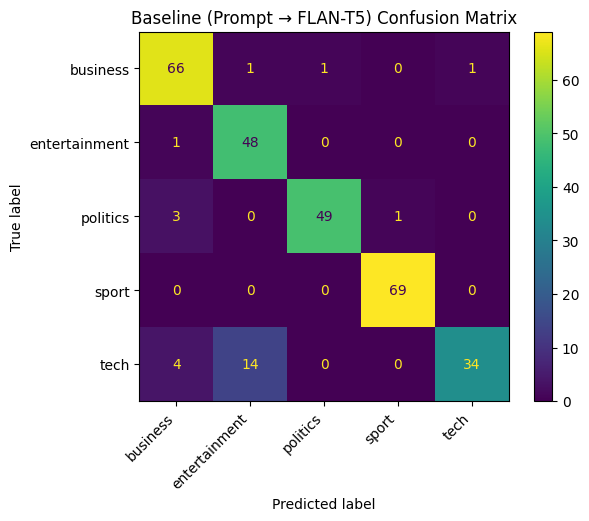

In [12]:
N = 300
df_test = ds_test.to_pandas()

df_small, _ = train_test_split(
    df_test,
    train_size=min(N, len(df_test)),
    stratify=df_test[LABEL_COL],
    random_state=SEED
)

test_small = ds_test.select(df_small.index.tolist())

y_true_b = []
y_pred_b = []

for ex in test_small:
    y_true_b.append(ex[LABEL_COL])
    y_pred_b.append(classify_with_flan_t5(ex[TEXT_COL]))

print(classification_report(y_true_b, y_pred_b, labels=label_names, digits=3, zero_division=0))

cm = confusion_matrix(y_true_b, y_pred_b, labels=label_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6,6))
disp.plot(values_format="d")
plt.xticks(rotation=45, ha="right")
plt.title("Baseline (Prompt → FLAN-T5) Confusion Matrix")
plt.show()

Save baseline predictions + metrics

In [13]:
os.makedirs("artifacts", exist_ok=True)

baseline_report = classification_report(
    y_true_b, y_pred_b, labels=label_names, output_dict=True, zero_division=0
)

with open("artifacts/baseline_metrics.json", "w") as f:
    json.dump(baseline_report, f, indent=2)

pd.DataFrame({"true": y_true_b, "pred": y_pred_b}).to_csv("artifacts/baseline_preds_subset.csv", index=False)

print("Saved: artifacts/baseline_metrics.json, artifacts/baseline_preds_subset.csv")

Saved: artifacts/baseline_metrics.json, artifacts/baseline_preds_subset.csv


# Part B — LoRA Fine-Tuning (F2LLM-0.6B, seq classification)

Tokenize datasets (for sequence classification)

In [14]:
from transformers import AutoTokenizer

FT_MODEL_ID = "codefuse-ai/F2LLM-0.6B"
tokenizer = AutoTokenizer.from_pretrained(FT_MODEL_ID, use_fast=True)

MAX_LEN = 192

def tok(batch):
    return tokenizer(
        batch[TEXT_COL],
        truncation=True,
        max_length=MAX_LEN,
        padding="max_length",
    )

ds_train_tok = ds_train.map(tok, batched=True)
ds_val_tok   = ds_val.map(tok, batched=True)
ds_test_tok  = ds_test.map(tok, batched=True)

# keep only tensors needed by Trainer
keep_cols = ["input_ids", "attention_mask", "label_id"]
ds_train_tok = ds_train_tok.remove_columns([c for c in ds_train_tok.column_names if c not in keep_cols])
ds_val_tok   = ds_val_tok.remove_columns([c for c in ds_val_tok.column_names if c not in keep_cols])
ds_test_tok  = ds_test_tok.remove_columns([c for c in ds_test_tok.column_names if c not in keep_cols])

# Trainer expects "labels"
ds_train_tok = ds_train_tok.rename_column("label_id", "labels")
ds_val_tok   = ds_val_tok.rename_column("label_id", "labels")
ds_test_tok  = ds_test_tok.rename_column("label_id", "labels")

ds_train_tok.set_format("torch")
ds_val_tok.set_format("torch")
ds_test_tok.set_format("torch")

print(ds_train_tok, ds_val_tok, ds_test_tok)

config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Map:   0%|          | 0/1557 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1557
}) Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 223
}) Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 445
})


Load seq-class model + pad token + speed settings

In [15]:
from transformers import AutoModelForSequenceClassification

# cleanup (helpful if you previously tried other runs)
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForSequenceClassification.from_pretrained(
    FT_MODEL_ID,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
)

# Set pad token (required for batch sizes > 1)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

# memory saver (trade compute for memory)
model.gradient_checkpointing_enable()

print("pad_token:", tokenizer.pad_token, tokenizer.pad_token_id)
print("model pad_token_id:", model.config.pad_token_id)

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/310 [00:00<?, ?it/s]

Qwen3ForSequenceClassification LOAD REPORT from: codefuse-ai/F2LLM-0.6B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


pad_token: <|endoftext|> 151643
model pad_token_id: 151643


Attach LoRA adapters

In [16]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
)

model = get_peft_model(model, lora_config)

# ensure pad_token_id survives PEFT wrapping
model.config.pad_token_id = tokenizer.pad_token_id
if hasattr(model, "get_base_model"):
    base = model.get_base_model()
    if hasattr(base, "config"):
        base.config.pad_token_id = tokenizer.pad_token_id

model.print_trainable_parameters()

trainable params: 4,592,640 || all params: 600,647,680 || trainable%: 0.7646


Trainer + bf16 training (fastest on your T4)

In [17]:
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
    }

args = TrainingArguments(
    output_dir="outputs_f2llm_lora",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,  # effective batch 16
    learning_rate=2e-4,
    num_train_epochs=3,
    weight_decay=0.01,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,

    bf16=True,
    fp16=False,

    optim="adamw_torch_fused",
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train_tok,
    eval_dataset=ds_val_tok,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,F1 Weighted
1,0.380955,0.084184,0.982063,0.982929,0.980220,0.981135,0.982031
2,0.277156,0.099032,0.982063,0.982552,0.981426,0.981879,0.982046
3,0.084902,0.138526,0.986547,0.986630,0.985348,0.985705,0.986540


TrainOutput(global_step=294, training_loss=0.6867964752271872, metrics={'train_runtime': 1380.001, 'train_samples_per_second': 3.385, 'train_steps_per_second': 0.213, 'total_flos': 2394892366774272.0, 'train_loss': 0.6867964752271872, 'epoch': 3.0})

Evaluate LoRA model on test set (full report + confusion)

               precision    recall  f1-score   support

     business      1.000     0.971     0.985       102
entertainment      0.974     0.987     0.981        77
     politics      0.988     0.988     0.988        84
        sport      0.990     1.000     0.995       102
         tech      0.988     1.000     0.994        80

     accuracy                          0.989       445
    macro avg      0.988     0.989     0.989       445
 weighted avg      0.989     0.989     0.989       445



<Figure size 600x600 with 0 Axes>

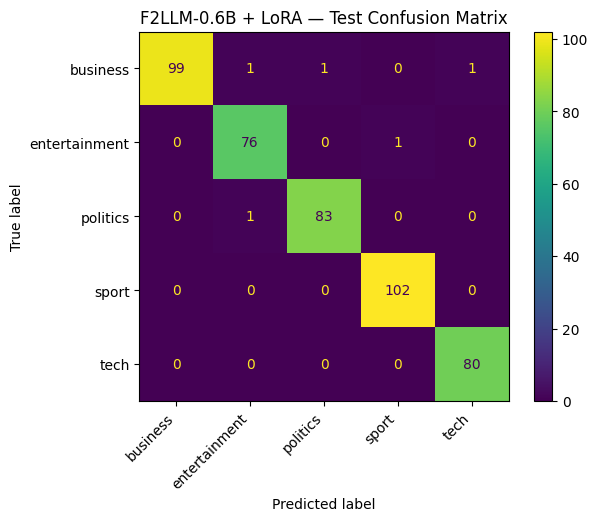

In [18]:
pred = trainer.predict(ds_test_tok)
y_true = pred.label_ids
y_hat  = np.argmax(pred.predictions, axis=-1)

print(classification_report(
    y_true, y_hat,
    target_names=label_names,
    digits=3,
    zero_division=0
))

cm = confusion_matrix(y_true, y_hat, labels=list(range(len(label_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6,6))
disp.plot(values_format="d")
plt.xticks(rotation=45, ha="right")
plt.title("F2LLM-0.6B + LoRA — Test Confusion Matrix")
plt.show()

Save LoRA adapters + tokenizer + metrics

In [19]:
os.makedirs("artifacts", exist_ok=True)

# Save adapters only (lightweight)
model.save_pretrained("artifacts/f2llm_lora_adapters")
tokenizer.save_pretrained("artifacts/f2llm_lora_adapters")

# Save test metrics
slm_report = classification_report(
    y_true, y_hat,
    target_names=label_names,
    output_dict=True,
    zero_division=0
)
with open("artifacts/slm_lora_test_metrics.json", "w") as f:
    json.dump(slm_report, f, indent=2)

pd.DataFrame({"true_id": y_true, "pred_id": y_hat}).to_csv("artifacts/slm_lora_test_preds.csv", index=False)

print("Saved adapters + metrics to artifacts/")

Saved adapters + metrics to artifacts/


Side-by-side comparison table (baseline subset vs fine-tuned test)

In [20]:
def extract_summary(report_dict):
    # report_dict is classification_report(output_dict=True)
    return {
        "accuracy": report_dict.get("accuracy", None),
        "macro_f1": report_dict["macro avg"]["f1-score"],
        "weighted_f1": report_dict["weighted avg"]["f1-score"],
    }

baseline_summary = extract_summary(baseline_report)
slm_summary = extract_summary(slm_report)

pd.DataFrame([
    {"model": "Prompt baseline (FLAN-T5) [subset]", **baseline_summary},
    {"model": "F2LLM-0.6B + LoRA [test]", **slm_summary},
])

,model,accuracy,macro_f1,weighted_f1
0,Prompt baseline (FLAN-T5) [subset],NaN,0.887848,0.895455
1,F2LLM-0.6B + LoRA [test],0.988764,0.988545,0.988748
